In [1]:
import os

import numpy as np
import pandas as pd

from scipy.interpolate import InterpolatedUnivariateSpline

import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

from tomso import gyre # !pip install tomso

In [2]:
class StellarModel():
    def __init__(self, gyre_filename, freqs_filename=None, eigenfunctions_dir=None):
        model = gyre.load_gyre(gyre_filename)
        self.gyre = model
        
        if freqs_filename is not None:
            self.freqs = pd.read_table(freqs_filename, sep=r'\s+', skiprows=5)
        
        # constants 
        self.M = model.M #1.989000000E+33 # g
        self.R = model.R #6.959894677E+10 # cm
        self.G = model.G #6.67428e-8
        
        # coordinates 
        x = model.x
        
        model.r[model.r == 0] = 1e-60
        model.m[model.m == 0] = 1e-60
        
        self.x = x
        self.r = model.r
        self.m = model.m
        
        # dimensional variables -- splines are denoted by underscores 
        self.cs2_    = InterpolatedUnivariateSpline(x, model.cs2)
        self.P_      = InterpolatedUnivariateSpline(x, model.P)
        self.rho_    = InterpolatedUnivariateSpline(x, model.rho)
        self.r_      = InterpolatedUnivariateSpline(x, model.r)
        
        self.N2_     = InterpolatedUnivariateSpline(x, model.N2)
        self.Gamma1_ = InterpolatedUnivariateSpline(x, model.Gamma_1)
        
        # dimensionless variables 
        As = model.AA
        c1 = model.r**3/model.R**3 * model.M/model.m
        V = -np.gradient(np.log(model.P), np.log(model.r))
        U = 4.*np.pi*model.r**3*model.rho/model.m
        
        if model.x[0] == 0:
            As[0] = 0
            V[0]  = 0
            U[0]  = 3
            c1[0] = model.M/model.R**3/(4/3*np.pi*model.rho[0])
        
        self.As_ = InterpolatedUnivariateSpline(x, model.AA)
        self.c1_ = InterpolatedUnivariateSpline(x, c1)
        self.V_  = InterpolatedUnivariateSpline(x, V)
        self.U_  = InterpolatedUnivariateSpline(x, U)
        
        self.Vg_ = lambda x: self.V(x)/self.Gamma1(x)
        #self.N2  = lambda y: g(x) * self.As_(x)
        
        self.eigs = {}
        if eigenfunctions_dir is not None:
            for fname in os.listdir(eigenfunctions_dir):
                if fname[:2] != '00':
                    continue
                eig_i = pd.read_table(os.path.join(eigenfunctions_dir, fname), sep='\s+', skiprows=5)
                sph_deg, rad_ord = fname.split('_')
                self.eigs[(int(sph_deg), 'x')] = eig_i['x']
                self.eigs[(int(sph_deg), int(rad_ord))] = eig_i[['Re(xi_r)', 'Re(xi_h)']]

    def plot_eigs(self, sph_deg, rad_ord):
        if self.eigs is None:
            return
        eigs = self.eigs
        
        x   = eigs[(sph_deg, 'x')]
        eig = eigs[(sph_deg, rad_ord)]
        plt.plot(x, eig['Re(xi_r)'], label='radial',     lw=3, zorder=11)
        plt.plot(x, eig['Re(xi_h)'], label='horizontal', lw=3, zorder=10)

        plt.xlabel(r'fractional radius $r/R$')
        plt.ylabel(r'eigenfunction $\xi$')
        plt.axhline(0, ls='--', c='k', alpha=1, zorder=-10)

        plt.xlim([0,1])
        plt.ylim([-20, 20])

        plt.suptitle(r'$\ell = {%d},\; n = {%d}$' % (sph_deg, rad_ord))
        plt.legend(loc='upper left')
    
    def eig_interact(self):
        interact(lambda sph_deg, rad_ord: self.plot_eigs(sph_deg, rad_ord), 
            sph_deg=IntSlider(min=0, max=3,  step=1, value=1), 
            rad_ord=IntSlider(min=5, max=30, step=1, value=15));
    
    def propagation_diagram(self):
        x = self.x
        S = 2*self.cs2_(x)/self.r_(x)**2
        plt.plot(x, self.N2_(x), label=r'$N^2$')
        plt.plot(x, S, label=r'$S_{\ell=1}^2$')
        plt.legend()
        plt.ylim([1e-10, 1e0])
        plt.ylabel(r'squared frequency [Hz$^2$]')
        plt.xlabel('r/R')
        plt.semilogy()
        plt.show()

In [3]:
# solar model computed using MESA including the effects of element diffusion
model1 = StellarModel('models/diffusion/solar.data.GYRE', 
                      'models/diffusion/solar-freqs.dat', 
                      'models/diffusion/eigenfunctions')

In [4]:
# solar model computed using MESA neglecting the effects of element diffusion
model2 = StellarModel('models/nodiffusion/solar.data.GYRE', 
                      'models/nodiffusion/solar-freqs.dat', 
                      'models/nodiffusion/eigenfunctions')

In [5]:
model1.freqs
# Re(freq) is the oscillation mode eigenfrequency 
# l is the spherical degree 
#     (l=0: radial, l=1: dipole, etc.) 
# n_pg is the radial order of the mode 
#     (i.e. the number of zero-points in the eigenfunction between the center and surface) 
# n_p, n_g are the p mode, g mode radial orders;  n_pg = n_p + n_g, where by convention n_g<0 
# E_norm is the mode inertia, which can be ignored for now. 

,E_norm,Re(freq),Im(freq),l,n_g,n_p,n_pg
0,3.191645e-05,824.908634,0.0,0,0,5,5
1,1.231019e-05,972.164103,0.0,0,0,6,6
2,5.230666e-06,1117.329457,0.0,0,0,7,7
3,2.267848e-06,1262.788827,0.0,0,0,8,8
4,1.013166e-06,1406.694364,0.0,0,0,9,9
...,...,...,...,...,...,...,...
102,8.697300e-09,3932.381692,0.0,3,0,26,26
103,8.801982e-09,4071.078318,0.0,3,0,27,27
104,8.937320e-09,4209.925778,0.0,3,0,28,28
105,9.149713e-09,4349.013034,0.0,3,0,29,29


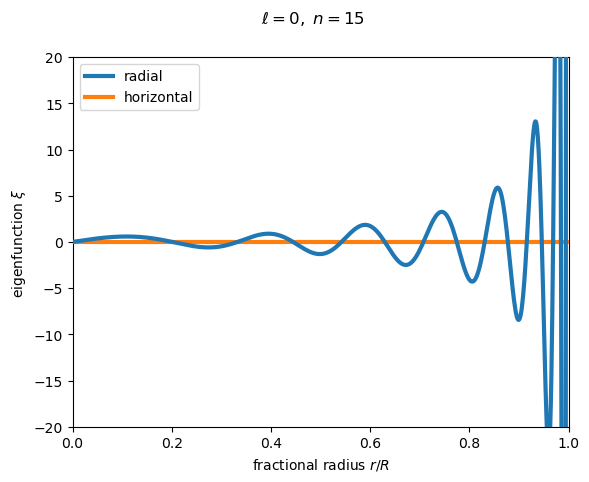

In [6]:
model1.plot_eigs(0, 15)

In [7]:
model1.eig_interact()

interactive(children=(IntSlider(value=1, description='sph_deg', max=3), IntSlider(value=15, description='rad_o…

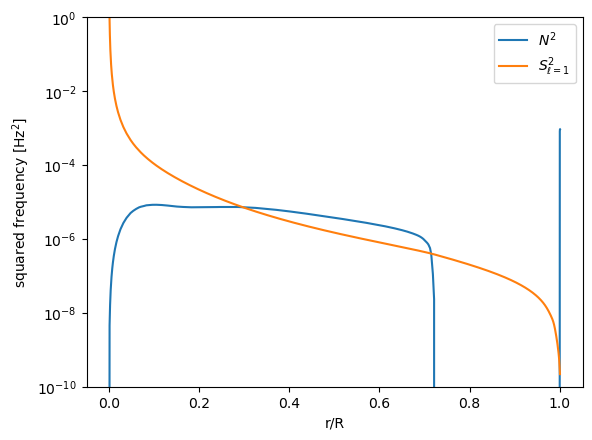

In [8]:
model1.propagation_diagram()

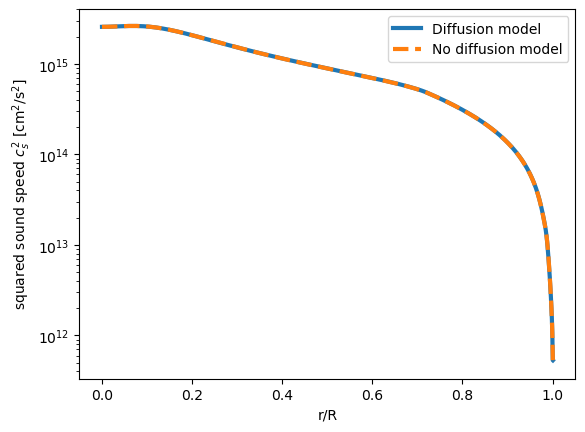

In [9]:
# sound speed profiles of the two models -- they are basically identical

x = model1.x
plt.plot(x, model1.cs2_(x), label='Diffusion model', lw=3)
plt.plot(x, model2.cs2_(x), ls='--', label='No diffusion model', lw=3)
plt.legend()
plt.semilogy()
plt.xlabel('r/R')
plt.ylabel(r'squared sound speed $c_s^2$ [cm$^2$/s$^2$]')
plt.show()

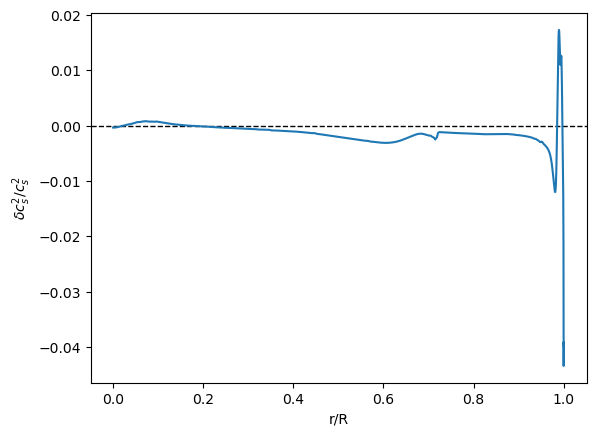

In [10]:
# differences in internal sound speed profile between the two models 
# they are at the ~1% level 

x = model1.x
m1_cs = model1.cs2_(x)
m2_cs = model2.cs2_(x)
plt.axhline(0, ls='--', c='k', lw=1)
plt.plot(x, (m2_cs-m1_cs)/m1_cs)
plt.xlabel('r/R')
plt.ylabel(r'$\delta c_s^2/c_s^2$')
plt.show()

In [11]:
merged = pd.merge(model1.freqs, model2.freqs, on=["l", "n_pg"])
merged['dnu'] = merged["Re(freq)_x"] - merged["Re(freq)_y"]
merged['dnu_nu'] = merged['dnu'] / merged["Re(freq)_x"]

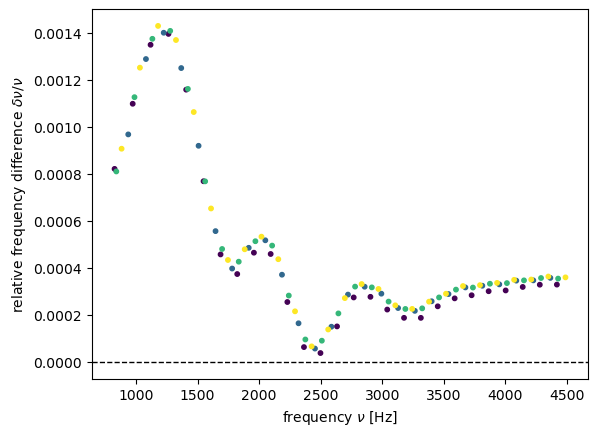

In [12]:
# compare eigenfrequency differences of the two models 

plt.axhline(0, ls='--', c='k', lw=1)
plt.scatter(merged['Re(freq)_x'], merged['dnu_nu'], s=10, c=merged['l'])
plt.xlabel(r"frequency $\nu$ [Hz]")
plt.ylabel(r'relative frequency difference $\delta\nu/\nu$')
plt.show()